In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import copy
import time
sns.set_style('whitegrid')

In [11]:
# Replace 'file_path.pkl' with the actual path to your pickle file
file_path = '/home/tyler/Documents/Matt3r/imu-classification/DATA/train_8s_stage3/ambient_turn/0a0a0b1a-27d9fc44_3.pkl'

# Open the pickle file in read-binary mode ('rb')
with open(file_path, 'rb') as file:
    # Load the contents of the pickle file into a Python object
    data_full = pickle.load(file)

In [12]:
data_full.keys()

dict_keys(['locations', 'accelerometer', 'gyro', 'metadata', 'label', 'matt3r_format'])

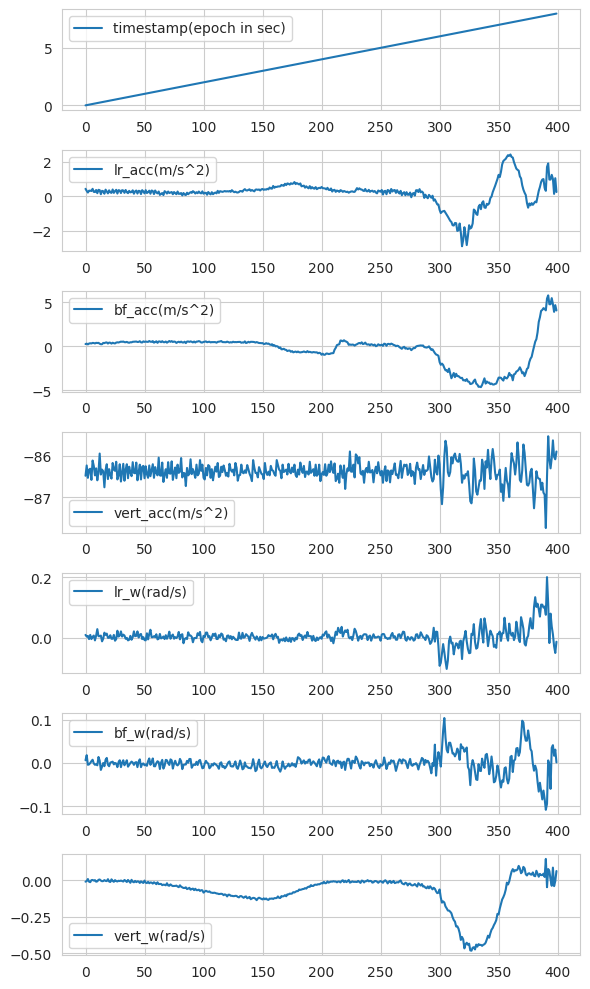

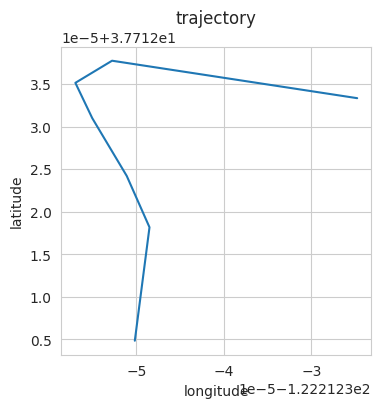

In [17]:
data = data_full['matt3r_format']
label = data_full['label']

# plot data, verify sanity by eye
plt.figure(figsize=(6, 10))
for i, key in enumerate(data.keys()):
    plt.subplot(7, 1, i+1)
    plt.plot(data[key], label=key)
    plt.legend()
plt.tight_layout()
plt.show()

# verify trajectory
latitudes = data_full['locations']['latitude']
longitudes = data_full['locations']['longitude']
plt.figure(figsize=(4, 4))
plt.plot(longitudes, latitudes)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('trajectory')
plt.show()

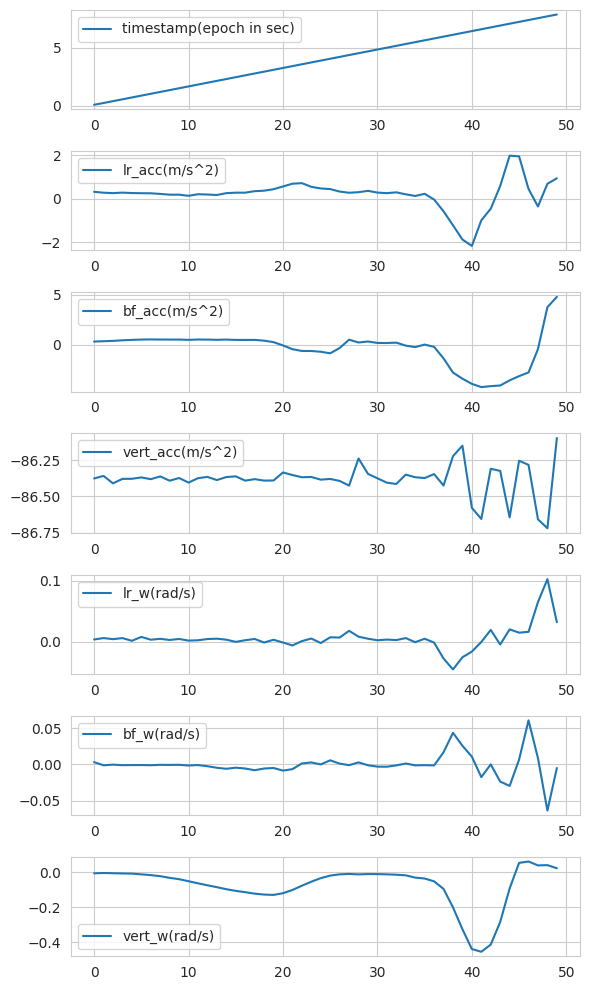

In [27]:
from scipy.ndimage import uniform_filter1d #TODO replace by Gaussian

def smoothen_and_discretize(sequence, window_size=None, discr_step=1):
    """Discretize a time sequence by taking the mean of each step
    
    Parameters:
    -----------
        sequence: 1D np.array
        step: int
    """
    if window_size:
        sequence = uniform_filter1d(sequence, size=window_size)

    if discr_step > 1:
        n = len(sequence)
        n_steps = int(np.ceil(n / discr_step))
        sequence = np.array([
            sequence[ i * discr_step:(i + 1) * discr_step].mean() 
            for i in range(n_steps)
        ])
    return sequence

# plot data, verify sanity by eye
WINDOW_SIZE = 6
DISC_STEP = 8  # time sequence of length 50

plt.figure(figsize=(6, 10))
for i, key in enumerate(data.keys()):
    plt.subplot(7, 1, i+1)
    
    plt.plot(
        smoothen_and_discretize(
                data[key],
                window_size=WINDOW_SIZE,
                discr_step=DISC_STEP, 
            ), 
        label=key
    )
    plt.legend()
plt.tight_layout()
plt.show()

# Experiment with Template Code

In [11]:
import os
import pickle
import numpy as np

In [4]:
folder_path = '/home/tyler/Documents/Matt3r/imu-classification/DATA/train_8s_stage3/right_turn_90'

right_turns = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".pkl"):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "rb") as file:
            data = pickle.load(file)
            right_turns.append(data['matt3r_format'])

In [45]:
import tslearn.utils
from scipy.ndimage import uniform_filter1d #TODO replace by Gaussian

def smoothen_and_discretize(sequence, window_size=None, discr_step=1):
    """Discretize a time sequence by taking the mean of each step
    
    Parameters:
    -----------
        sequence: 1D np.array
        step: int
    """
    if window_size:
        sequence = uniform_filter1d(sequence, size=window_size)

    if discr_step > 1:
        n = len(sequence)
        n_steps = int(np.ceil(n / discr_step))
        sequence = np.array([
            sequence[ i * discr_step:(i + 1) * discr_step].mean() 
            for i in range(n_steps)
        ])
    return sequence

# plot data, verify sanity by eye
WINDOW_SIZE = 6
DISC_STEP = 8  # time sequence of length 50

right_turn_list = []
for turn in right_turns:
    # right_turn_list.append(smoothen_and_discretize(turn['lr_acc(m/s^2)'], WINDOW_SIZE, DISC_STEP))
    right_turn_list.append(smoothen_and_discretize(turn['vert_w(rad/s)'], WINDOW_SIZE, DISC_STEP))

X_train = tslearn.utils.to_time_series(right_turn_list[:100])

X_train.shape

(100, 50)

Soft-DTW k-means
0.195 --> 0.294 --> 0.301 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 0.306 --> 


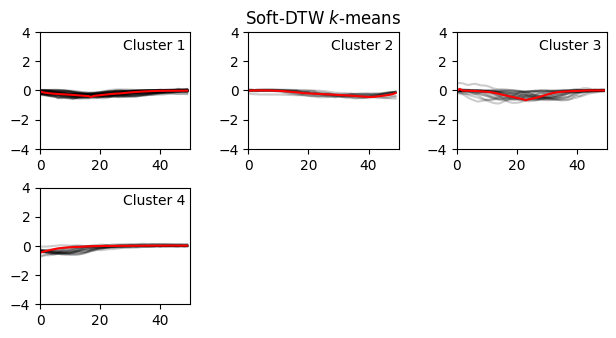

In [48]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
numpy.random.seed(seed)
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# X_train = X_train[y_train < 4]  # Keep first 3 classes
# numpy.random.shuffle(X_train)
# # Keep only 50 time series
# X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
# # Make time series shorter
# X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]

clusters = 4

# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(clusters):
    plt.subplot(3, 3, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()

In [12]:
# Author: Romain Tavenard
# License: BSD 3 clause

import numpy
from sklearn.metrics import accuracy_score

from tslearn.generators import random_walk_blobs
from tslearn.preprocessing import TimeSeriesScalerMinMax, \
    TimeSeriesScalerMeanVariance
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, \
    KNeighborsTimeSeries

numpy.random.seed(0)
n_ts_per_blob, sz, d, n_blobs = 20, 100, 1, 2

# Prepare data
X, y = random_walk_blobs(n_ts_per_blob=n_ts_per_blob,
                         sz=sz,
                         d=d,
                         n_blobs=n_blobs)
scaler = TimeSeriesScalerMinMax(value_range=(0., 1.))  # Rescale time series
X_scaled = scaler.fit_transform(X)

indices_shuffle = numpy.random.permutation(n_ts_per_blob * n_blobs)
X_shuffle = X_scaled[indices_shuffle]
y_shuffle = y[indices_shuffle]

X_train = X_shuffle[:n_ts_per_blob * n_blobs // 2]
X_test = X_shuffle[n_ts_per_blob * n_blobs // 2:]
y_train = y_shuffle[:n_ts_per_blob * n_blobs // 2]
y_test = y_shuffle[n_ts_per_blob * n_blobs // 2:]

# Nearest neighbor search
knn = KNeighborsTimeSeries(n_neighbors=3, metric="dtw")
knn.fit(X_train, y_train)
dists, ind = knn.kneighbors(X_test)
print("1. Nearest neighbour search")
print("Computed nearest neighbor indices (wrt DTW)\n", ind)
print("First nearest neighbor class:", y_test[ind[:, 0]])

# Nearest neighbor classification
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")
knn_clf.fit(X_train, y_train)
predicted_labels = knn_clf.predict(X_test)
print("\n2. Nearest neighbor classification using DTW")
print("Correct classification rate:", accuracy_score(y_test, predicted_labels))

# Nearest neighbor classification with a different metric (Euclidean distance)
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="euclidean")
knn_clf.fit(X_train, y_train)
predicted_labels = knn_clf.predict(X_test)
print("\n3. Nearest neighbor classification using L2")
print("Correct classification rate:", accuracy_score(y_test, predicted_labels))

# Nearest neighbor classification based on SAX representation
metric_params = {'n_segments': 10, 'alphabet_size_avg': 5}
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="sax",
                                         metric_params=metric_params)
knn_clf.fit(X_train, y_train)
predicted_labels = knn_clf.predict(X_test)
print('probability', knn_clf.predict_proba(X_test))
print("\n4. Nearest neighbor classification using SAX+MINDIST")
print("Correct classification rate:", accuracy_score(y_test, predicted_labels))

1. Nearest neighbour search
Computed nearest neighbor indices (wrt DTW)
 [[10 12  2]
 [ 0 13  5]
 [ 0  1 13]
 [ 0 11  5]
 [16 18 12]
 [ 3 17  9]
 [12  2 16]
 [ 7  3 17]
 [12  2 10]
 [12  2 18]
 [12  8  2]
 [ 3 17  7]
 [18 19  2]
 [ 0 17 13]
 [ 9  3  7]
 [12  2  8]
 [ 3  7  9]
 [ 0  1 13]
 [18 10  2]
 [10 12  2]]
First nearest neighbor class: [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0]

2. Nearest neighbor classification using DTW
Correct classification rate: 1.0

3. Nearest neighbor classification using L2
Correct classification rate: 1.0
probability [[0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666

In [8]:
y_test

array([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0])

In [16]:
X_test.shape

(20, 100, 1)

# End to end KNN method

In [1]:
import os
import pickle
import numpy as np
import random
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, \
    KNeighborsTimeSeries

/home/tyler/.local/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Collect the training data

In [93]:
training_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/train_8s_stage3'
validation_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/val_8s_stage3'

SAMPLES_PER_CLASS = 100

def shuffle_data_set(X, Y=None, size=None):
    indices = list(range(len(X)))
    random.shuffle(indices)
    shuffled_X = [X[i] for i in indices][:size]
    if Y is not None:
        shuffled_Y = [Y[i] for i in indices][:size]
        return shuffled_X, shuffled_Y
    else: return shuffled_X

# collect data for either training or validation
def get_data(folder_path, n_samples):
    num_classes = 0
    X = []
    Y = []
    labels = []
    for id, folder in enumerate(os.listdir(folder_path)):
        labels.append(folder)
        folder_list = []
        for file_name in os.listdir(os.path.join(folder_path, folder)):
            if file_name.endswith(".pkl"):
                file_path = os.path.join(folder_path, folder, file_name)
                with open(file_path, "rb") as file:
                    data = pickle.load(file)
                    folder_list.append(data['matt3r_format'])
        X += shuffle_data_set(folder_list, size=n_samples)
        Y += [id] * n_samples
        if id >= num_classes:
            num_classes += 1
    # shuffle the datasets
    X_shuffled, Y_shuffled = shuffle_data_set(X, Y, n_samples * num_classes)
    return X_shuffled, Y_shuffled, labels


X_train, Y_train, class_labels = get_data(training_directory, SAMPLES_PER_CLASS)
X_val, Y_val, _ = get_data(validation_directory, SAMPLES_PER_CLASS)

Preprocessing the data

In [88]:
def preprocess_data(X, Y):
    SIGMA = 2.5
    FINAL_SEQ_LENGTH = 50
    offset = (400 / FINAL_SEQ_LENGTH) / 2
    DOWNSAMPLING_INDEXES = np.linspace(offset, 400-offset, FINAL_SEQ_LENGTH).round().astype(int)

    mins = np.inf * np.ones(6)
    maxs = -np.inf * np.ones(6)

    X_preprocessed = []
    for timeseries in X:
        # convert to numpy
        data_np = np.vstack([timeseries[col] for col in timeseries])[1:,:]
        # smoothen
        data_smooth = gaussian_filter1d(data_np, sigma=SIGMA, mode='nearest')
        # downsample
        data_discr = data_smooth[:, DOWNSAMPLING_INDEXES]
        X_preprocessed.append(data_discr)

        # update the max and mins for normalization
        mins = np.min([mins, np.min(data_discr, axis=1)], axis=0)
        maxs = np.max([maxs, np.max(data_discr, axis=1)], axis=0)

    ranges = maxs - mins

    print(maxs, mins)

    mins = mins[:, np.newaxis]
    ranges = ranges[:, np.newaxis]

    X_normalized = []
    for data in X_preprocessed:
        # normalize to -1..1 per column
        data = ((data - mins) / ranges) * 2 - 1
        X_normalized.append(data[[0,1,5]].T)

    return to_time_series_dataset(X_normalized), np.array(Y)

ts_X_train, ts_Y_train = preprocess_data(X_train, Y_train)
ts_X_val, ts_Y_val = preprocess_data(X_val, Y_val)

[ 6.90541282  7.72618801 11.22713151 17.03170347  2.38002637  1.91222142] [-6.13470371 -6.52096086 -9.8591711  -3.65821146 -7.838122   -0.90109703]
[ 6.78883231 12.51584602  4.69520421  1.47358781  0.66265837  0.8021304 ] [ -8.09183895 -11.40118864  -9.80862189  -1.83272985  -1.34564942
  -1.13776359]


In [96]:
# trying individual max/min normalization

def preprocess_data(X, Y):
    SIGMA = 2.5
    FINAL_SEQ_LENGTH = 50
    offset = (400 / FINAL_SEQ_LENGTH) / 2
    DOWNSAMPLING_INDEXES = np.linspace(offset, 400-offset, FINAL_SEQ_LENGTH).round().astype(int)

    X_preprocessed = []
    for timeseries in X:
        # convert to numpy
        data_np = np.vstack([timeseries[col] for col in timeseries])[1:,:]
        # smoothen
        data_smooth = gaussian_filter1d(data_np, sigma=SIGMA, mode='nearest')
        # downsample
        data_discr = data_smooth[:, DOWNSAMPLING_INDEXES]
        # normalize
        maxs = np.max(data_discr, axis=1)
        mins = np.min(data_discr, axis=1)
        ranges = maxs - mins
        mins = mins[:, np.newaxis]
        ranges = ranges[:, np.newaxis]
        data_norm = ((data_discr - mins) / ranges) * 2 -1
        X_preprocessed.append(data_norm[[0,1,5]].T)
        
    return to_time_series_dataset(X_preprocessed), np.array(Y)

ts_X_train, ts_Y_train = preprocess_data(X_train, Y_train)
ts_X_val, ts_Y_val = preprocess_data(X_val, Y_val)

In [22]:
# moving average filtering

WINDOW_SIZE = 6
DISC_STEP = 8  # time sequence of length 50

def smoothen_and_discretize(sequence, window_size=None, discr_step=1):
    """Discretize a time sequence by taking the mean of each step
    
    Parameters:
    -----------
        sequence: 1D np.array
        step: int
    """
    if window_size:
        sequence = uniform_filter1d(sequence, size=window_size)

    if discr_step > 1:
        n = len(sequence)
        n_steps = int(np.ceil(n / discr_step))
        sequence = np.array([
            sequence[ i * discr_step:(i + 1) * discr_step].mean() 
            for i in range(n_steps)
        ])
    return sequence

def preprocess_data(X, Y):
    processed_X = []
    for timeseries in X:
        lr_acc = smoothen_and_discretize(timeseries['lr_acc(m/s^2)'], WINDOW_SIZE, DISC_STEP)
        bf_acc = smoothen_and_discretize(timeseries['bf_acc(m/s^2)'], WINDOW_SIZE, DISC_STEP)
        vert_gy = smoothen_and_discretize(timeseries['vert_w(rad/s)'], WINDOW_SIZE, DISC_STEP)
        processed_X.append(np.vstack((vert_gy, lr_acc, bf_acc)))
    ts_X = to_time_series_dataset(processed_X)
    ts_Y = np.array(Y)
    return ts_X, ts_Y

ts_X_train, ts_Y_train = preprocess_data(X_train, Y_train)
ts_X_val, ts_Y_val = preprocess_data(X_val, Y_val)

In [80]:
ts_X_train.shape

(600, 50, 1)

Implement KNN

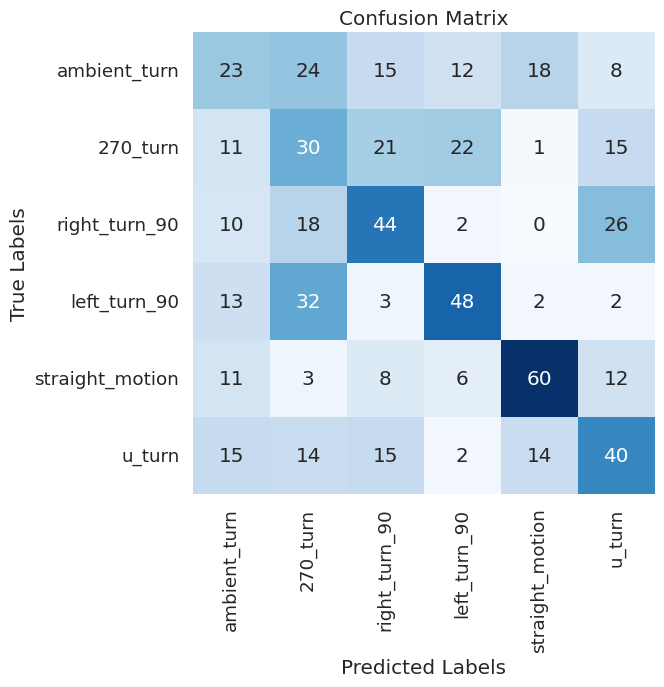

In [97]:
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="softdtw")
knn_clf.fit(ts_X_train, ts_Y_train)
predicted_labels = knn_clf.predict(ts_X_val)

# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(ts_Y_val, predicted_labels)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_labels)